*This jupyter notebook is part of Arizona State University's course CAS 503 (Fundamentals of Complex Systems Science: Collectives) and was written by Bryan Daniels.  It was last updated September 26, 2024.*

# Dynamics on Networks and Collective Modes

In this exercise, we'll run simple spreading dynamics on a few networks and compute collective modes to predict the result of these dynamics.

Run the following cell to set up code for running the dynamics and plotting the results.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path # to handle file paths across all operating systems

# networkx is a popular python package for dealing with networks
import networkx as nx
# temporary patch for networkx 2.7.1 under scipy 1.7.3
from helpers.networkx_patch import * 
# scipy's `eigs` function computes eigenvalues and eigenvectors of a (sparse) matrix
from scipy.sparse.linalg import eigs
# the prettynet package makes simple network visualizations
from prettynet.prettynet import view,nodeColors

def spreadingDynamics(weightMatrix,initialState,numTimesteps=100):
    """
    Implements simple network dynamics in which states at each node spread to neighboring nodes
    at rates given by weightMatrix.
    
    weightMatrix             : (N x N) array defining rate of spread between nodes
                               (w_ij corresponds to the rate of spreading from node j to node i)
    initialState             : length N vector defining the initial state
    numTimesteps (100)       : number of timesteps to simulate
    
    Returns:
    stateList                : ( (numTimesteps + 1) x N ) array of states at each time point
    """
    stateList = [ initialState, ]
    state = np.copy(initialState)
    for t in range(numTimesteps):
        state = np.dot(weightMatrix,state)
        stateList.append(state)
    return np.array(stateList)

### 1) Dynamics on a simple example network

The following cell creates the simple example network that appears in this week's lecture.  (Feel free to change or add to these edges.)

In [3]:
# construct a simple example by hand by listing the network's edges
edges = [(0,3),
         (1,3),
         (2,3),
         (3,4),
         (4,5),
         (4,6),
         (4,7),
         (5,8),
         (6,9),
         (6,10),
         (7,11),
         (9,12),
         (9,13)]
G = nx.from_edgelist(edges)

`G` is a network (aka graph) object created by the `networkx` package.  It contains the network's nodes and edges and can be used to output various useful representations of the network, including its adjacency matrix:

In [4]:
nx.adjacency_matrix(G).toarray()

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

The `view` function outputs a visualization of the network.  (Note that this will look slightly different than the visualization I showed in lecture, because I have since updated to use newer software. You can verify that it's still the same network!)

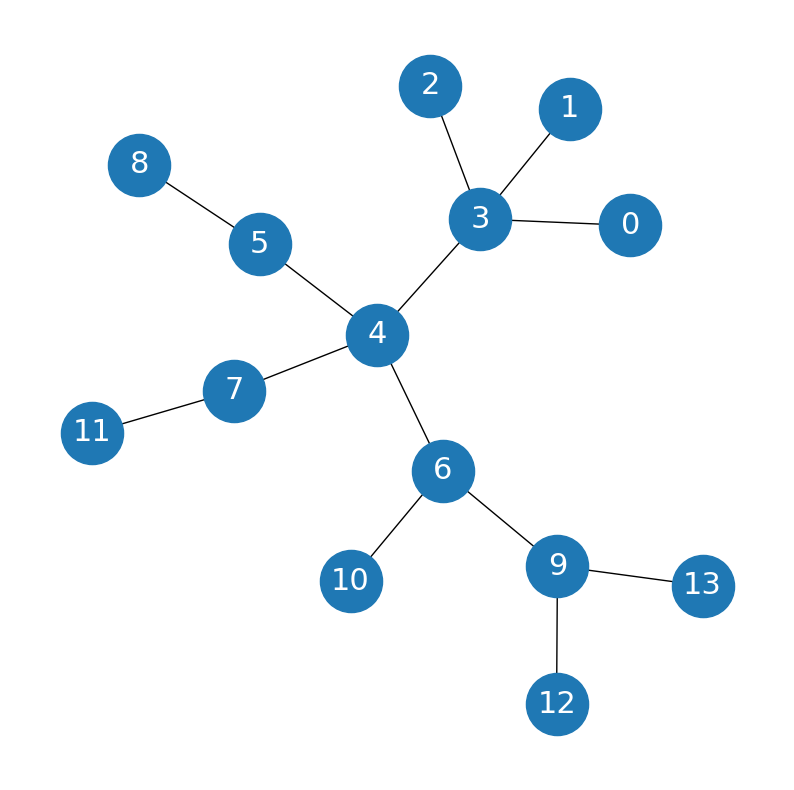

In [5]:
view(G)

Now let's run dynamics on the network.  The following code initializes the nodes to each have a value of 1, then takes a single step of the simple spreading dynamics defined in this week's lecture (simply adding the value of each node to all its neighbors' states):

State vector after 1 timesteps = [2. 5. 2. 2. 5. 3. 4. 3. 2. 4. 2. 2. 2. 2.]


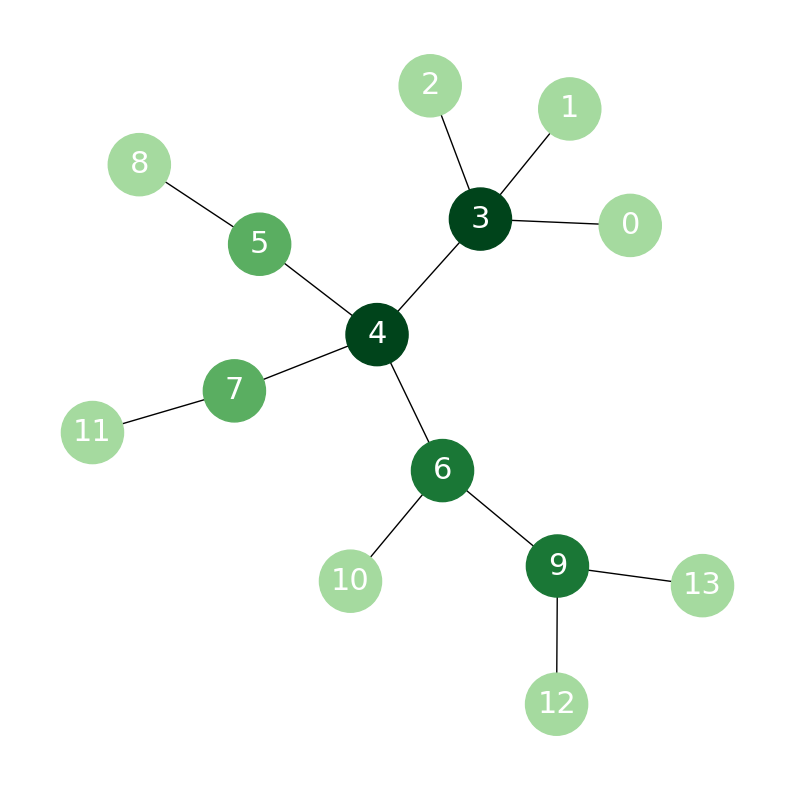

In [6]:
# set up the weight matrix that defines the dynamics
# (note that we have to add the identity matrix (`np.eye`, the matrix with ones on the diagonal 
#  and zeros on the off-diagonal) to the adjacency matrix, so that at each step each node both 
#  keeps its current value and adds to that the input it gets from neighboring nodes)
weightMatrix = nx.adjacency_matrix(G).toarray() + np.eye(G.number_of_nodes())
# run dynamics, starting from the state in which each node has value 1
initialState = [ 1,1,1,1,1,1,1,1,1,1,1,1,1,1 ]
numTimesteps = 1
stateList = spreadingDynamics(weightMatrix,initialState,numTimesteps)

# print state vector and visualize state after numTimesteps
# (colors in the visualization are rescaled so that the largest value corresponds to dark green)
state = stateList[numTimesteps]
print("State vector after {} timesteps = {}".format(numTimesteps,state))
view(G,node_color=nodeColors(state, G.nodes))

❓**Modify the above code to run the dynamics for multiple timesteps. About how many steps does it take for the relative pattern of states to stop changing?**

✳️ **Answer:** 

❓**After many steps of the dynamics, what do you expect the pattern of states to look like in terms of the eigenvectors of the weight matrix?** *Hint: Recall that each eigenvector consists of a list of numbers, one for each node. (We calculate these eigenvectors explicitly below.)  Based on what we covered in the lecture on collective modes, which eigenvector is the relevant one?*

✳️ **Answer:** 

Does the final pattern depend on the starting point?  
❓**Modify the simulation so that the system starts with a value of 1 at a single node and zeros everywhere else (by changing `initialState`).  How many steps does it now take for the pattern to settle down?**

✳️ **Answer:** 

### 2) Collective modes of the simple example network

Now we'll compute the principal eigenvectors of the adjacency matrix (those with the largest eigenvalues) to check your prediction.  Given a matrix, the `eigs` function returns the principal eigenvalues and eigenvectors.  (By default it computes the 6 with largest eigenvalues.)

In [7]:
# compute first few dominant eigenmodes (the eigs function by default computes 6 of them)
weightMatrix = nx.adjacency_matrix(G) + np.eye(G.number_of_nodes())
vals,vecs = eigs(weightMatrix)

# do some housekeeping to make our lives easier
# (sort to have largest magnitude first, drop any imaginary parts if possible,
#  and transpose the eigenvectors so that the first index corresponds to the 
#  eigenvector index instead of the node index)
order = np.argsort(abs(vals))[::-1]
vals,vecs = np.real_if_close(vals)[order],np.transpose(np.real_if_close(vecs)[:,order])

Here are the first 6 eigenvalues:

In [8]:
vals

array([ 3.46347475,  2.81045695,  2.41421356,  2.        ,  1.80841685,
       -1.46347475])

Here's the eigenvector with largest eigenvalue (remember that `0` is the index of the first item in a list in python):

In [9]:
vecs[0]

array([-0.17947091, -0.44212204, -0.17947091, -0.17947091, -0.55074377,
       -0.26767046, -0.3792804 , -0.26767046, -0.10865566, -0.22964237,
       -0.15396156, -0.10865566, -0.09321888, -0.09321888])

❓**Use the `view` function to visualize the network with colors corresponding to the eigenvector to which you expect the dynamics to converge.** *Hint: See above for an example of using the `node_color` argument to `view`. Make sure you are not just replotting the final network state.*  Does the eigenvector look the same as the result you got using the dynamics above?

In [10]:
# ✳️ Answer:

### 3) Dynamics on a real-world network

It is relatively easy nowadays to access data describing real-world networks.  Let's explore!

❓**Download a real-world network dataset from an online repository and run the above collective mode analysis on it.**  *Hint: Feel free to either find your own way here or follow my lead using the notes below.*

✳️ **Answer:** 

Once you've run the analysis, if you haven't already, do a bit of research to find out where your network came from and what it represents.  

❓**Describe in words how you would interpret the dominant collective mode you found in terms of real-world consequences**.

✳️ **Answer:** 

### Suggested method for finding and loading network data:

First, find an interesting network dataset.  I would recommend the Network Repository website: http://networkrepository.com/

A word of caution: It's easy to find networks that are too large for your computer to analyze easily!  I would recommend looking for a network with fewer than about 1000 nodes (the number of nodes is listed as |V| at the above website).

To load a list of edges from a file, try using `np.loadtxt` as I have here.  You'll need to know where the file is on your system (path names use forward slashes for Mac/Linux, backward slashes for Windows...).

(Note that I used the argument `usecols=(0,1)` to only read in the first two columns in the `.edges` file.  Some networks on the Network Repository website have extra columns in the `.edges` file that we won't use here.)

In [11]:
edgeFilename = Path(r'/Users/bryandaniels/Downloads/bn-mouse_visual-cortex_2/bn/bn-mouse_visual-cortex_2.edges')
edges = np.loadtxt(edgeFilename,usecols=(0,1),dtype=int)

FileNotFoundError: /Users/bryandaniels/Downloads/bn-mouse_visual-cortex_2/bn/bn-mouse_visual-cortex_2.edges not found.

Look at the first few edges in your edge list to make sure they look reasonable:

In [ ]:
edges[:10]

Then create a `networkx` network using `nx.from_edgelist`:

In [ ]:
G = nx.from_edgelist(edges)

In [ ]:
view(G,node_size=400,font_size=12)

Once you have your network loaded, use code from the previous section to find (and hopefully plot) its dominant collective mode.